<a href="https://colab.research.google.com/github/pg2455/hackathons/blob/master/COVID_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 diagnosis using symptoms

[Prateek Gupta](https://www.pgupta.info) 

2020-05-20

**Abstract:** This notebook is a tutorial on building a typical machine learning classifier. 
The process of doing so span steps ranging from data wrangling to model selection. 
With the help of each of these steps we hope to make the reader familiar with challenges involved in building a machine learning system. 

# Question

In this tutorial, we want to build a machine learning model to predict COVID-19 infections from symptoms.
It has several applications, for example, triaging patients to be attended by a doctor or nurse, recommending self-isolation through contact tracing apps. 

Zoabi et al. [[1]](https://www.nature.com/articles/s41746-020-00372-6) builds a decision tree classifier using the publicly available data reported by the Israeli Ministry of Health.
The paper itself dicsusses the various challenges encountered in deploying such a model. 
It is encouraged to read the paper and learn the challeges and ways to overcome them. 

However, in this tutorial, we will use their dataset and make the reader familiar with a typical pipeline of building a machine learning system.
As we go through the tutorial, we will also be listing out things to try. 

[1] [Zoabi, Y., Deri-Rozov, S. & Shomron, N. Machine learning-based prediction of COVID-19 diagnosis based on symptoms. npj Digit. Med. 4, 3 (2021).]((https://www.nature.com/articles/s41746-020-00372-6))


# Setup the workspace

We will clone their Git repository to to use their dataset

In [ ]:
!git clone https://github.com/nshomron/covidpred.git

Cloning into 'covidpred'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 35 (delta 16), reused 10 (delta 3), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [ ]:
import pandas as pd
import math
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Data 

Let's check how the data looks like and how various features are encoded. 

In [ ]:
df = pd.read_csv('covidpred/data/corona_tested_individuals_ver_006.english.csv.zip')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.columns

Index(['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'corona_result', 'age_60_and_above', 'gender',
       'test_indication'],
      dtype='object')

Great! These are the features used in the paper for their prediction task. The authors also list these features in the [README.md of their Github repo](https://github.com/nshomron/covidpred). 

Pandas read columns as string, so we need to convert them to the proper format before we can operate on it.

In [ ]:
df['test_date'] = pd.to_datetime(df['test_date'])

In [ ]:
print("Start date:", min(df['test_date']))
print("End date:", max(df['test_date']))

n_days = (max(df['test_date']) - min(df['test_date'])).days
print("# of days: ", n_days)

n_obs =  df.shape[0]
print("# of observations:", df.shape[0])
print("# of features:", df.shape[1])

pos_cases = sum(df['corona_result'] == "positive")
print("# of positively diagnosed cases: {0} ({1: 2.2f}%)".format(pos_cases, 100*pos_cases / n_obs))

neg_cases = sum(df['corona_result'] == "negative")
print("# of negatively diagnosed cases: {0} ({1: 2.2f}%)".format(neg_cases, 100 * neg_cases / n_obs))

other_cases = sum(df['corona_result'] == "other") # possibly not confirmed
print("# of other cases (possibly, not confirmed): {0} ({1: 2.2f}%)".format(other_cases, 100 * other_cases / n_obs))

Start date: 2020-03-11 00:00:00
End date: 2020-04-30 00:00:00
# of days:  50
# of observations: 278848
# of features: 10
# of positively diagnosed cases: 14729 ( 5.28%)
# of negatively diagnosed cases: 260227 ( 93.32%)
# of other cases (possibly, not confirmed): 3892 ( 1.40%)


Since we do not have any information on what happened to "other" cases, we will exclude them from our exercise. 



In [ ]:
df = df[df['corona_result'].isin(['positive', 'negative'])]

To build out predictor, we will be splitting our dataset into **training,  validation, and test sets**. 
A model is trained on the training dataset while the hyperparameters are tuned on the validation dataset. 
Finally, a test dataset is used to report final model's performance metrics. 

Since we have a time dependent dataset we will split our training and test dataset based on time. 
Thus, we find the date before which 600% of observations are present, and use that as our training dataset.
We will use next 20% of the dataset as our validation dataset, and finally, the remaining 20% will be used as a test dataset. 
Thus, we use 60-20-20 split.

The authors use 63%-23% training-test split, and a further split of training into train-valid dataset using 80-20% split.
There is no prescribed formula on how to do this split. 



In [ ]:
date_counts = df.groupby(['test_date']).count()['gender'] # take count of any column. They will all be same.
date_counts = date_counts.sort_index()
cum_counts = date_counts.cumsum()
cdf = cum_counts / n_obs


In [ ]:
max_training_date = cdf[cdf < 0.60].index.max()
training_data = df[df['test_date'] <= max_training_date]

min_test_date = cdf[cdf > 0.80].index.min()
test_data = df[df['test_date'] >= min_test_date]

valid_data = df[(max_training_date < df['test_date']) & (df['test_date'] < min_test_date)]

print("# of observations in training dataset", training_data.shape[0])
print("# of observations in validation dataset", valid_data.shape[0])
print("# of observations in test dataset", test_data.shape[0])

# of observations in training dataset 160717
# of observations in validation dataset 53172
# of observations in test dataset 61067


**NOTE:**
It is **extremely important** that you do not use the test dataset in the model building phase. 
While building models, it will be required to tune the hyperparameter, adjust assumptions, modify features, etc. 
This should be done on the validation dataset. 
After several such iterations on the validation dataset, you will pick a model with the best performace as your final model. 

A test dataset is used to measure the final model's performance, which is a proxy for how it will perform (or generalize) in real life. 
Thus, to have a proper measure of model's genearalization, test dataset should not be part of your model building process. 

# Exploratory Data Analysis

In this section, we will see the general statistics of features.
In doing so, we will encounter inconsistencies in the data and address them accordingly. 


In [ ]:
# We want to predict 'corona_result'. 
# We will not use "test_date" as a feature. 
# So we narrow down the input features to this list 
INPUT_FEATURES = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']
TARGET_COLUMN = 'corona_result'

for col in INPUT_FEATURES:
  print("*"*25, f" {col} ", "*"*25)
  print(training_data[col].value_counts())

*************************  cough  *************************
0       119702
1        25547
0        12039
1         3177
None       252
Name: cough, dtype: int64
*************************  fever  *************************
0       131874
0        13768
1        13375
1         1448
None       252
Name: fever, dtype: int64
*************************  sore_throat  *************************
0       142874
0        15973
1         1435
1          434
None         1
Name: sore_throat, dtype: int64
*************************  shortness_of_breath  *************************
0       143279
0        15906
1         1030
1          501
None         1
Name: shortness_of_breath, dtype: int64
*************************  head_ache  *************************
0       142294
0        16064
1         2015
1          343
None         1
Name: head_ache, dtype: int64
*************************  age_60_and_above  *************************
No      123867
Yes      25425
None     11425
Name: age_60_and_above, dtype: 

We make note of two points here - 

1. There are values which are *present twice as unique values*. How is this possible?
2. There are column values "None" in the dataset. What can these values mean? Should we use them in our model? If so, how do we represent them?

We will address the questions related to the second observation in the next section. 

For now, let's look at the unique values of one of these columns. 





In [ ]:
training_data['cough'].unique()

array([0, 1, '0', '1', 'None'], dtype=object)

Ok! So a value of 0 is used in the dataset in two ways - an integer (0) and a string ("0"). 
Therefore, we will need to convert all such values to a common datatype. 
Here, we will convert all strings to integers. 

In [ ]:
def normalize(x):
  """
  Normalizes the input to integer type. It maps "None" to 2.

  Args:
    x (int or str): input to be normalized 
  
  Returns:
    (int): normalized input
  """
  if type(x) == str:
    return int(x) if x != "None" else 2
  return x



for col in ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']:
  training_data.loc[:, col] = training_data[col].apply(normalize)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
training_data['cough'].value_counts()

0    131741
1     28724
2       252
Name: cough, dtype: int64

Great! So we fixed the incoherence in data formats. Let's plot the histograms of the categorical values. 

**GOOD PRACTICE**: To make your plots accessible to everyone, it is always a good idea to use colorblind-friendly palette for your plots. Check out [this](https://medium.com/cafe-pixo/inclusive-color-palettes-for-the-web-bbfe8cf2410e) for such a palette.

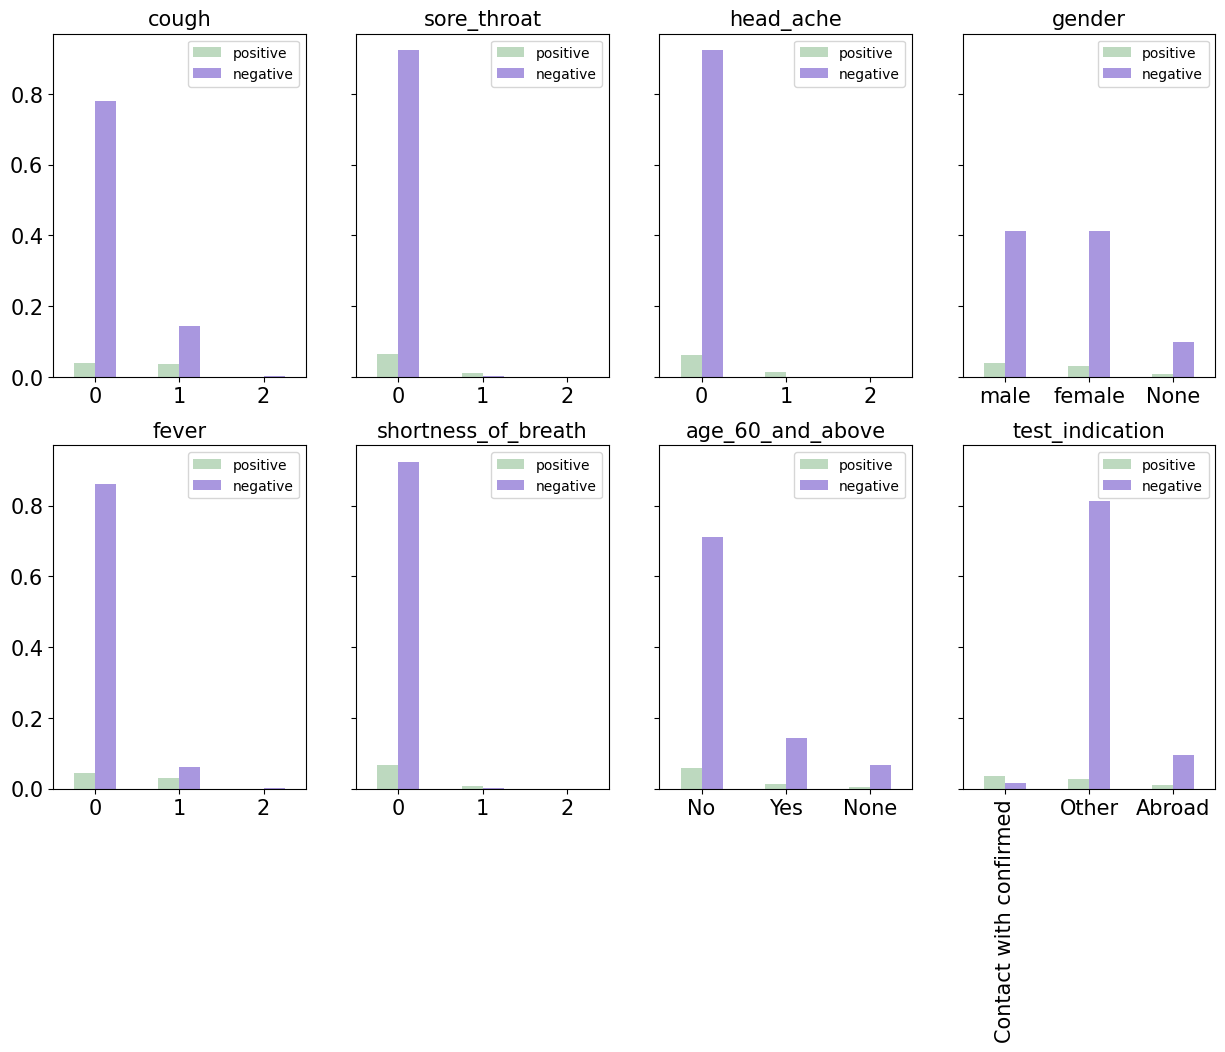

In [ ]:
nrows = 2
ncols = math.ceil(len(INPUT_FEATURES) / nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), dpi=100, sharey=True)

colormap = {"positive": "#BDD9BF", "negative": "#A997DF"}

for i, col in enumerate(INPUT_FEATURES):
  ax = axs[i % 2][i // 2]
  counts = training_data[col].value_counts()

  # counts for positive results
  pos_prob = training_data[training_data[TARGET_COLUMN] == 'positive'][col].value_counts() / sum(counts)

  # counts for negative results
  neg_prob = training_data[training_data[TARGET_COLUMN] == 'negative'][col].value_counts() / sum(counts)

  # plot
  pd.concat([pos_prob.rename('positive'), neg_prob.rename('negative')], axis=1).plot(kind="bar", ax=ax, color=colormap)

  # basic plot formatting
  ax.set_title(col, fontsize=15)

  # tick size
  for tick in ax.xaxis.get_major_ticks():
      tick.label.set_fontsize(15)
      tick.label.set_rotation(0)
      if tick.label.get_text() == "Contact with confirmed":
        tick.label.set_rotation(90)

  for tick in ax.yaxis.get_major_ticks():
      tick.label.set_fontsize(15)


The dataset itself has "class imbalance", i.e there are far more number of `Negative` observations than the `Positive` observations. 
The models usually output scores that are interpreted as indication for belonging to class 1 if the score is greater than 0.5 and 0 otherwise. 
With a class imbalance, the models tend to get better for inputs that belong to the class which is present in majority.
This tendency pushes the average score towards the majority class. 
Thus, the techniques like resampling (re-weighting the loss function so that minority class is appropriately weighted) or threshold-moving (selecting the threshold other than 0.5) will be required to interpret the model scores.
There are [various other techniques](https://elitedatascience.com/imbalanced-classes) that are used to handle the challenges posed by imbalanced datasets.

Further, we make note of the biased features which the authors point out in their work. 
They recognize `sore_throat`, `shortness_of_breath`, and `head_ache` as biased features because a `Positive` case was more likely to *report* them (and been further validated by epidemiologists). 
This can be seen by a "green" bar higher than the "purple" bar for the value of 1 in the plots of the aforementioned features. 

Let's look at `corona_result` when these features are reported. 
One might jump to a conclusion that there is a high likelihood of being COVID positive if one of these features are present. 
However, this conclusion stands upon the underlying bias in data collection, therefore we need to be careful while including these features. 
This is where a close collaboration with experts (e.g, public health officials, epidemiologists, etc.) can help. 

For now, let's zoom in on the statistics of `corona_result` when the aforementioned features are present.



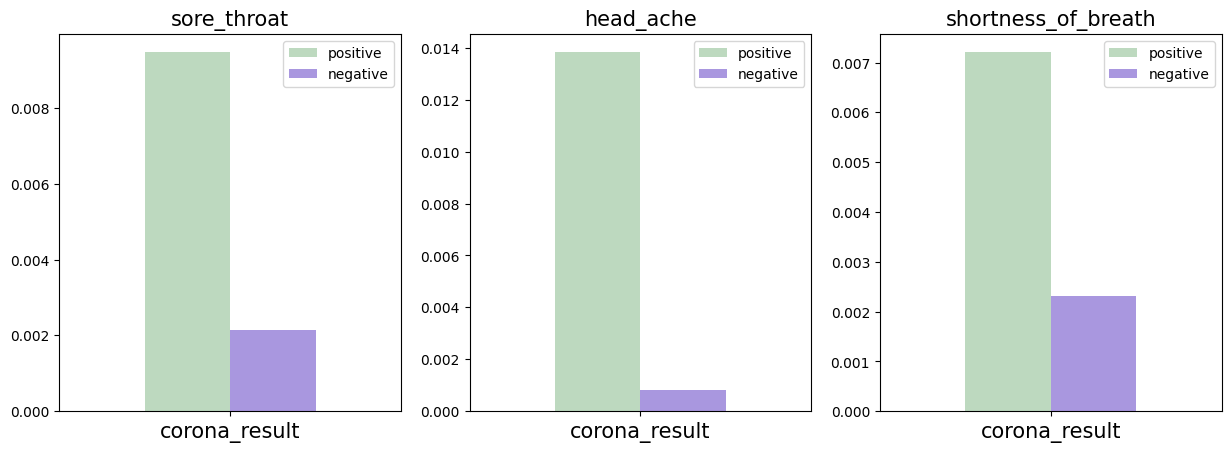

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=100)

for i, col in enumerate(['sore_throat', 'head_ache', 'shortness_of_breath']):
  ax = axs[i]
  counts = training_data[col].value_counts()

  # counts of positive when this col was 1
  result_prob = training_data[training_data[col] == 1][TARGET_COLUMN].value_counts() / sum(counts)

  result_prob = pd.DataFrame(result_prob).transpose() # converts series to dataframe with column to be read by the `colormap`
  result_prob.plot(kind="bar", ax=ax, color=colormap)

  # basic plot formatting
  ax.set_title(col, fontsize=15)

  # tick size
  for tick in ax.xaxis.get_major_ticks():
      tick.label.set_fontsize(15)
      tick.label.set_rotation(0)

  for tick in ax.yaxis.get_major_ticks():
      tick.label.set_fontsize(10)


How do we deal with such biases?
The authors made another model without the use of these features.

In our exercise, however, we will build a model using all of these features. 
It is left as an exercise to the reader to try a model without the biased features. 

# Feature Engineering

In this section, we will transform the features that models can operate upon. Note that this transformation doesn't have to be unique. 
It is very much dependent on the type of model you are building. 

Since all of the features are categorical we will use one-hot-encoding for our features.
We will assume "None" as a separate category. 
It is because the absence of a feature might also contain useful information for predicting the target. 

We will be using [`sklearn`'s functions](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to get our one-hot-encoded dataset, but it can also be done without any external library. 

In [ ]:
encoder = OneHotEncoder()
encoder.fit(training_data[INPUT_FEATURES]) 

# NOTE: encoder will transform features of training_data according to the ** column sequence specified by INPUT_FEATURES **. 
# ecoder will not know the labels of these features. It only looks at column and transforms them into several columns for each category in that column. The ordering is preserved. 
print("Encoded categories:\n")
print(encoder.categories_) # what are the categories identified by the encoder

print("\nColumn names: \n")
print(encoder.get_feature_names(input_features=INPUT_FEATURES)) # what are the names of these cateogories

print("\nInput data shape: \n")
print(training_data.shape)

print("\nOne-hot encoded data shape: \n")
print(encoder.transform(training_data[INPUT_FEATURES]).shape)

Encoded categories:

[array([0, 1, 2]), array([0, 1, 2]), array([0, 1, 2]), array([0, 1, 2]), array([0, 1, 2]), array(['No', 'None', 'Yes'], dtype=object), array(['None', 'female', 'male'], dtype=object), array(['Abroad', 'Contact with confirmed', 'Other'], dtype=object)]

Column names: 

['cough_0' 'cough_1' 'cough_2' 'fever_0' 'fever_1' 'fever_2'
 'sore_throat_0' 'sore_throat_1' 'sore_throat_2' 'shortness_of_breath_0'
 'shortness_of_breath_1' 'shortness_of_breath_2' 'head_ache_0'
 'head_ache_1' 'head_ache_2' 'age_60_and_above_No' 'age_60_and_above_None'
 'age_60_and_above_Yes' 'gender_None' 'gender_female' 'gender_male'
 'test_indication_Abroad' 'test_indication_Contact with confirmed'
 'test_indication_Other']

Input data shape: 

(160717, 10)

One-hot encoded data shape: 

(160717, 24)


All of the 8 input features had 3 cateogories. 
Therefore, after the one-hot encoding of these features the resulting dataset has 24 columns - one for each category in each column. 

Note that there is a redundancy in representing all three categories for each feature.
If there are only three possible values for a feature, absence of any two cateogories will imply presence of the third category. 
Therefore, one of the three columns for each feature will be redundant (i.e. no extra information to help our models).

Let's drop one of these categories for each feature. 
We can achieve this by passing `drop` argument to our encoder.

In [ ]:
encoder = OneHotEncoder(drop='first').fit(training_data[INPUT_FEATURES]) 

print("Encoded categories:\n")
print(encoder.categories_) 

print("\nColumn names: \n")
print(encoder.get_feature_names(input_features=INPUT_FEATURES)) 

print("\nInput data shape: \n")
print(training_data.shape)

print("\nOne-hot encoded data shape: \n")
print(encoder.transform(training_data[INPUT_FEATURES]).shape)

print("\nOne-hot encoded data (sparse format:  stores indices and values only for cells with non-zero values) : \n")
print(encoder.transform(training_data[INPUT_FEATURES]))

print("\nOne-hot encoded data (dense format): \n")
print(encoder.transform(training_data[INPUT_FEATURES]).todense())



Encoded categories:

[array([0, 1, 2]), array([0, 1, 2]), array([0, 1, 2]), array([0, 1, 2]), array([0, 1, 2]), array(['No', 'None', 'Yes'], dtype=object), array(['None', 'female', 'male'], dtype=object), array(['Abroad', 'Contact with confirmed', 'Other'], dtype=object)]

Column names: 

['cough_1' 'cough_2' 'fever_1' 'fever_2' 'sore_throat_1' 'sore_throat_2'
 'shortness_of_breath_1' 'shortness_of_breath_2' 'head_ache_1'
 'head_ache_2' 'age_60_and_above_None' 'age_60_and_above_Yes'
 'gender_female' 'gender_male' 'test_indication_Contact with confirmed'
 'test_indication_Other']

Input data shape: 

(160717, 10)

One-hot encoded data shape: 

(160717, 16)

One-hot encoded data (sparse format:  stores indices and values only for cells with non-zero values) : 

  (0, 10)	1.0
  (0, 13)	1.0
  (0, 15)	1.0
  (1, 10)	1.0
  (1, 13)	1.0
  (1, 15)	1.0
  (2, 10)	1.0
  (2, 13)	1.0
  (2, 15)	1.0
  (3, 10)	1.0
  (3, 12)	1.0
  (3, 15)	1.0
  (4, 10)	1.0
  (4, 13)	1.0
  (4, 15)	1.0
  (5, 10)	1.0
  (5, 

Great! We will use this `econder` to transform all our datasets. 
Our target is `corona_result`. 
We will use standard `sklearn` format to binarize our target. 

In [ ]:
lb = LabelBinarizer()
lb.fit(training_data['corona_result'])

print("What are the classes identified by LabelBinarizer?")
print(lb.classes_)

print("\nHow are these classes represeted?")
print(lb.get_params())

print("\nHow will the transformed training targets look like?")
print("\nBefore transformation:")
print(np.array(training_data[TARGET_COLUMN].tolist()))
print("\nAfter transformation")
print(lb.transform(training_data[TARGET_COLUMN]).flatten()) # use .flatten() to convert the array into a 1D array because we have binary labels.


What are the classes identified by LabelBinarizer?
['negative' 'positive']

How are these classes represeted?
{'neg_label': 0, 'pos_label': 1, 'sparse_output': False}

How will the transformed training targets look like?

Before transformation:
['negative' 'negative' 'negative' ... 'negative' 'positive' 'negative']

After transformation
[0 0 0 ... 0 1 0]


Let's write a function to do the above transformations so that we can call the same function on different datasets.

In [ ]:
def preprocess(data, encoder, lb):
  """
  Transforms `data` into format required for model building

  Args:
    data (pd.DataFrame): dataframe with columns `INPUT_FEAUTURES` and `TARGET_COLUMN`
    encoder (sklearn.preprocessing.OneHotEncoder): A fitted OneHotEncoder to be used to transform `INPUT_FEATURES`
    lb (sklearn.preprocessing.LabelBinarizer): A fitted LabelBinarizer to be used to transform `TARGET_COLUMN`
  
  Returns:
    model_input (np.array): each row is an observation, columns are one-hot encoded features of `INPUT_FEATURES`
    model_target (np.array): 1D array with 1 where `TARGET_COLUMN` is "positive" and 0 otherwise.
  """

  x = encoder.transform(data[INPUT_FEATURES]).todense()
  y = lb.transform(data[TARGET_COLUMN]).flatten() 

  return x, y

# Model building

In this section, we will build a very simple [logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) using `sklearn`. 

**TRY:** The task for this tutorial will be to try various other classifiers that you have learned so far.
Here is the list of models to try :

*   Decision Trees: [User Guide](https://scikit-learn.org/stable/modules/tree.html#classification). [API](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). You can head down in the User Guide to [other Tree algorithms](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) if you fancy. 
*   Categorical Naive Bayes.[User Guide](https://scikit-learn.org/stable/modules/naive_bayes.html#categorical-naive-bayes). [API](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB)
*   Linear Discriminant Analysis. [User Guide](https://scikit-learn.org/stable/modules/lda_qda.html#). [API](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis)
*   Quadratic Discriminant Analysis. [User Guide](https://scikit-learn.org/stable/modules/lda_qda.html#). [API](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis)
*   Support Vector Machines. [User Guide](https://scikit-learn.org/stable/modules/svm.html#classification). [API](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
*   Nearest neighbors classification. [User Guide](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification). [API](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
*   Neural networks - Multi-layer Perceptron (MLP). [User Guide](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#multi-layer-perceptron). [API](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)



In [ ]:
X_train, Y_train = preprocess(training_data, encoder, lb)
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Evaluate Model

In this section, we will evaluate our model's performance on the validation dataset. 

A model outputs a probability that the input is a "positive" case. 
While using this model in real life, we will want to know a threshold probability above which we can classify that input as "positive" and recommend necessary actions. 
If a threshold is too low, we are bound to classify some "negative" cases as "positive" (False Positive). 
On the other hand, if the threshold is too high, we will be classifying some "positive" cases as "negative" (False Negative).

As you can see, there is a trade-off between these False Positives and False Negatives. 
We convert the rate of such predictions into False Positive Rate (FPR) (fraction of false positives out of all true negative inputs) and False Negative Rates (FNR) (fraction of false negatives out of all true positive inputs).
It is by convention that we consider a trade-off between FPR and 1-FNR (True Positive Rate or TPR).
This trade-off is usually visualized in the form of a Reciever Operating Characteristics (ROC). 

How do we summarize this trade-off into a single number or a metric?
This is where we use Area Under the Curve (AUC) of ROC. 
Consider an oracle model that predicts a likelihood of 0 for all inputs that are "negative" and any value greater than 0 for all inputs that are "positive". For such an oracle, no matter what a threshold you choose, its FPR will always be 0 and TPR will be 1 (or FNR will be 0). 
AUC for such an oracle ROC will be 1 (area of the square of side 1). 
This is what we are aiming for when we build our models. 
Hence, our metric of evaluation is ROC AUC, where we want to aim for a model that has an ROC AUC of 1.

There are standard functions to compute these scores in `sklearn`, so we will use them. 
Specifically, we will be using [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) and [`plot_roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html).

Question of which threshold to use will be answered in conjunction with authorities that will be using such a system.
If we were to use this system for triaging patients, a false positive would probably result in a wasted PCR test, and a false negative will result in more infections. 
On the other hand, if this model were to be used for recommending self-isolation, a false positive will result in some form of economic cost by restricting the individual to home (assuming work from home is not possible), and a false negative will result in more infections.
Thus, deciding which threshold to use will depend on the ideologies and preference of the authorities that you work with.
Therefore, one needs to be good at communicating the complex concepts in machine learning to experts in other domains not cognizant of such details. 


AUC ROC score for the model: 0.82602918308811 



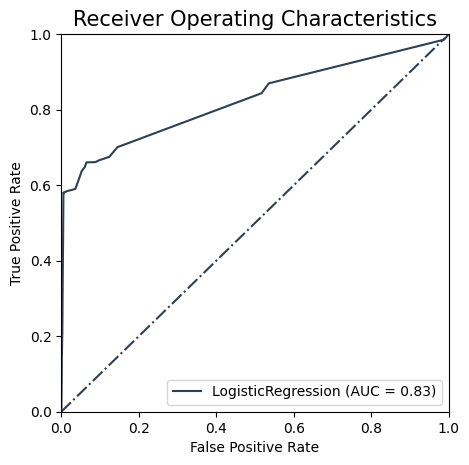

In [ ]:
X_valid, Y_valid = preprocess(valid_data, encoder, lb)
y_score = model.predict_proba(X_valid) # (n_samples, n_clases) with each value being the probability of being in that class

print("AUC ROC score for the model:", roc_auc_score(y_true = Y_valid, y_score= y_score[:, 1]), "\n")

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)
plot_roc_curve(model, X_valid, Y_valid, ax =ax, color="#2E4052")

# formatting 
ax.plot(np.arange(0,1, 0.01), np.arange(0, 1, 0.01), color="#2E4052", linestyle="-.") # reference line
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
_ = ax.set_title("Receiver Operating Characteristics", fontsize=15)

Great! Let's define a function that can do this evaluation for us. 

In [ ]:
def evaluate(model, X, Y):
  """
  Returns the AUC-ROC for `model` as evaluated on (X, Y)

  Args:
    model (): Any model that has a function predict_proba and returns probability for each row in `X`.
    X (np.array): Input to the model containing feature values
    Y (np.array): 1D array containing true class i.e. 0 or 1
  
  Returns:
    (float): AUC ROC for the model
  """

  y_score = model.predict_proba(X) # (n_samples, n_clases) with each value being the probability of being in that class
  return roc_auc_score(y_true=Y, y_score=y_score[:, 1])

# Hyperparameter Search

In this section we will be searching for the best parameters to build our logistic model. This is where we will use our validation dataset. 

Specifically, we will fine-tune the `l2` regularizer's strength. 
This parameter is controlled by the parameter `C` in `sklearn`. 



In [ ]:
best_auc = -1
best_C = None
for C in [1e-4, 1e-3, 1e-2, 1e-1]:
  model = LogisticRegression(C=C)
  model.fit(X_train, Y_train)
  auc_score = evaluate(model, X_valid, Y_valid)
  if auc_score > best_auc:
    best_model = model
    best_auc = auc_score
    best_C = C

print(f"Found the best model with C:{best_C} of AUC-ROC: {best_auc}")


Found the best model with C:0.001 of AUC-ROC: 0.8363914374551177


Hyperparameter search can become messy if you have lots of paramters. 
A brute force method to do such a search will be to do a grid search to fit tons of models. 
Thus, a smarter way to do hyperparameter search has been the subject of research. 

**TRY:** If interested, read [here](https://scikit-learn.org/stable/modules/grid_search.html) for more details and incorporate some of those ideas in the model building process. 

# Report your results

**NOTE:** You should use the test dataset only when you are done with hyperparameter search on your model. 
This is because the test dataset is not involved in the model building process, thereby making sure that the performance evaluation on the test dataset measures how well the proposed model is able to generalize.

In [ ]:
X_test, Y_test = preprocess(test_data, encoder, lb)
auc_score = evaluate(best_model, X_test, Y_test)
print(f"AUC-ROC on the test dataset:{auc_score}")


AUC-ROC on the test dataset:0.8114507841261618


How do we select a threshold?
Typically, we select a threshold which has high TPR and a low FPR. 
Thus, we would select a threshold at which TPR - FPR is maximum. 
If we have the model scores, we can slide the threshold and compute TPR and FPR for all those threshold values. 
This is conviniently done by `sklearn`'s `roc_curve` function. 

In [ ]:
y_score = best_model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(Y_test, y_score[:, 1])
idx = np.argmax(tpr - fpr)
chosen_threshold = thresholds[idx]

print(f"The threshold with maximum (TPR - FPR) is: {chosen_threshold}")

The threshold with maximum (TPR - FPR) is: 0.03428982148383669


Great! Where is this threshold located on the ROC curve?

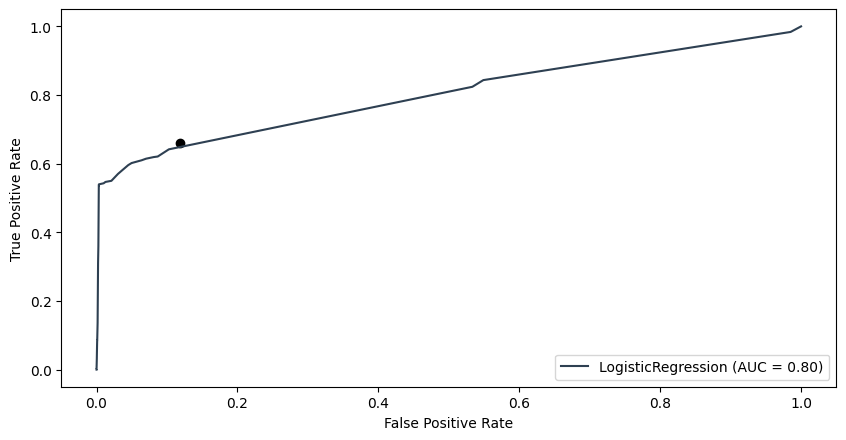

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)

plot_roc_curve(model, X_test, Y_test, color="#2E4052", ax =ax)
_ = ax.scatter(fpr[idx], tpr[idx], marker='o', color='black')

# Collaborate with Ensemble 

You can combine various models to form an ensemble model. 
There are various ways to combine these models. 
All of them serve a particular purpose (e.g. reducing variance, increasing accuracy. etc.). 

The simplest example of an ensemble is to combine the constituent models via voting. This can be done in two ways:
*  soft voting - likelihood of the input belonging to a class is the mean of the likelihood predicted by the constituent models, 
*  hard-voting - likelihood of the input belonging to a class is determined by frequency of the constutuent models predicting that class for the input.

Thus, if you are working in a team, let each member try out different models. At the end, combine your models and make an ensemble model. 

Here is the [User Guide](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier) and [API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) for making such an ensemble model.

# Extras: Class imbalance

**TRY:** 
As pointed out earlier, the dataset has class imbalance. 
Why not try resampling techniques to optimize for ROC AUC?




# Extras: Dimensionality Reduction

**TRY:** You can try dimensionality reduction from 16 dimensions to just 2 dimensions and visualize 2D plot with just two categories - "positive" and "negative". 
To do this, try various dimension reduction techniques, for example, [LDA](https://scikit-learn.org/stable/modules/lda_qda.html#mathematical-formulation-of-lda-dimensionality-reduction), [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA), [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). 


# Poster template 

It is often the most difficult task to communicate the project's finding concisely in 1 minute or in a 1 slide. 
Therefore, our suggestion will be to touch upon the following points in your poster -  

1. Briefly define the problem
2. Briefly describe the dataset 
3. What did you learn about various models/techniques/etc.? e.g. 
4. What's the auc score of your final model did you get?

If you want to learn what matters in building such posters, check out this great [YouTube video](https://www.youtube.com/watch?v=1RwJbhkCA58).
Specifically, we should try and avoid posters with a lot of stuff to avoid cognitive overload. 
The templates suggested in the video can be found [here](https://osf.io/ef53g/). 
Note these are for academic papers, however, you can follow a similar ideology to concizsely display your work. 